# Project Nova: Three-Model Fairness Analysis

This notebook provides comprehensive analysis of our three-model fairness framework:
- **Baseline Model**: Standard ML without fairness constraints
- **Equalized Odds Model**: Post-processing threshold optimization
- **Reweighing Model**: Pre-processing with fairness-aware training

## Setup and Data Loading

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("📊 Project Nova - EDA and Fairness Analysis")
print("=" * 50)

📊 Project Nova - EDA and Fairness Analysis


## Load Dataset

In [26]:
# Load the generated dataset
data_path = Path('../data/partners.csv')

if data_path.exists():
    df = pd.read_csv(data_path)
    print(f"✅ Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
    
    # Load metadata if available
    meta_path = Path('../data/metadata.json')
    if meta_path.exists():
        with open(meta_path) as f:
            metadata = json.load(f)
        print(f"📋 Metadata: {metadata}")
else:
    print("❌ Dataset not found. Please run the data generation first:")
    print("   python src/generate_data.py --n 50000 --seed 42 --out data/partners.csv")
    df = None

✅ Dataset loaded: 50,000 rows, 21 columns
📋 Metadata: {'n_rows': 50000, 'seed': 42, 'label': 'defaulted_12m', 'sensitive_attributes': ['gender', 'region', 'role']}


## Data Overview

In [27]:
if df is not None:
    print("🔍 Dataset Info:")
    print(df.info())
    print("\n📈 Basic Statistics:")
    display(df.describe())

🔍 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   partner_id                50000 non-null  int64  
 1   role                      50000 non-null  object 
 2   region                    50000 non-null  object 
 3   gender                    50000 non-null  object 
 4   age                       50000 non-null  int64  
 5   tenure_months             50000 non-null  int64  
 6   earnings_monthly          50000 non-null  float64
 7   trips_weekly              50000 non-null  float64
 8   on_time_rate              50000 non-null  float64
 9   cancel_rate               50000 non-null  float64
 10  customer_rating           50000 non-null  float64
 11  safety_incidents_12m      50000 non-null  int64  
 12  wallet_txn_count_monthly  50000 non-null  float64
 13  wallet_txn_value_monthly  50000 non-null  flo

,partner_id,age,tenure_months,earnings_monthly,trips_weekly,on_time_rate,cancel_rate,customer_rating,safety_incidents_12m,wallet_txn_count_monthly,wallet_txn_value_monthly,income_volatility,seasonality_index,prior_loans,prior_defaults,fuel_cost_share,defaulted_12m
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.00000
mean,25000.500000,41.023160,41.816020,1043.370520,96.424207,0.927781,0.041343,4.685785,0.049940,84.917080,451.059361,0.251346,1.001151,0.18182,0.051780,0.126141,0.07794
std,14433.901067,13.598046,23.957004,366.538209,34.273384,0.046782,0.027692,0.225693,0.222726,34.874920,178.174926,0.117969,0.249391,0.38570,0.221585,0.092814,0.26808
min,1.000000,18.000000,1.000000,200.000000,5.000000,0.719909,0.000000,3.572052,0.000000,0.000000,0.000000,0.000000,0.300000,0.00000,0.000000,0.000000,0.00000
25%,12500.750000,29.000000,21.000000,792.925016,70.524120,0.895859,0.019870,4.531741,0.000000,61.188748,330.613098,0.169975,0.834111,0.00000,0.000000,0.000000,0.00000
50%,25000.500000,41.000000,42.000000,1006.175600,95.287837,0.929716,0.039931,4.699960,0.000000,84.924371,451.157491,0.250170,1.000608,0.00000,0.000000,0.152101,0.00000
75%,37500.250000,53.000000,62.000000,1249.767225,121.180648,0.963676,0.060403,4.869042,0.000000,108.524107,570.755932,0.331829,1.170183,0.00000,0.000000,0.198827,0.00000
max,50000.000000,64.000000,83.000000,3060.743696,250.190877,1.000000,0.159597,5.000000,3.000000,230.686603,1245.041069,0.745289,2.000000,1.00000,1.000000,0.382679,1.00000


## Three-Model Comparison Analysis

Now let's compare our three fairness approaches across key metrics and examine specific partner examples.

In [28]:
# Load the three model outputs
baseline_path = Path('../data/partners_scores_baseline.csv')
fair_path = Path('../data/partners_scores_fair.csv')
reweighed_path = Path('../data/partners_scores_reweighed.csv')

# Check if model outputs exist
if baseline_path.exists() and fair_path.exists() and reweighed_path.exists():
    df_baseline = pd.read_csv(baseline_path)
    df_fair = pd.read_csv(fair_path)
    df_reweighed = pd.read_csv(reweighed_path)
    
    print(f'✅ Loaded three model outputs:')
    print(f'   Baseline: {len(df_baseline):,} partners')
    print(f'   Fair (Equalized Odds): {len(df_fair):,} partners')
    print(f'   Reweighed: {len(df_reweighed):,} partners')
    
    # Show columns for each model
    print(f'\n📋 Column comparison:')
    print(f'   Baseline columns: {list(df_baseline.columns)}')
    print(f'   Fair columns: {list(df_fair.columns)}')
    print(f'   Reweighed columns: {list(df_reweighed.columns)}')
else:
    print('❌ Model output files not found. Please run the training pipeline first.')
    df_baseline = df_fair = df_reweighed = None

✅ Loaded three model outputs:
   Baseline: 12,500 partners
   Fair (Equalized Odds): 12,500 partners
   Reweighed: 12,500 partners

📋 Column comparison:
   Baseline columns: ['partner_id', 'prob_default', 'nova_score', 'decision']
   Fair columns: ['partner_id', 'prob_default', 'nova_score', 'decision_fair', 'decision_baseline']
   Reweighed columns: ['partner_id', 'prob_default', 'nova_score', 'decision_reweighed', 'prob_default_baseline', 'nova_score_baseline', 'decision_baseline']


In [29]:
if df_baseline is not None and df_fair is not None and df_reweighed is not None:
    # Decision distribution comparison
    print('🎯 Decision Distribution Comparison:')
    print(f'Baseline positive decisions: {df_baseline["decision"].sum():,}')
    print(f'Fair positive decisions: {df_fair["decision_fair"].sum():,}')
    print(f'Reweighed positive decisions: {df_reweighed["decision_reweighed"].sum():,}')
    
    # Nova score comparison
    print('\n📊 Nova Score Statistics:')
    print(f'Baseline mean Nova score: {df_baseline["nova_score"].mean():.1f}')
    print(f'Fair mean Nova score: {df_fair["nova_score"].mean():.1f}')
    print(f'Reweighed mean Nova score: {df_reweighed["nova_score"].mean():.1f}')

🎯 Decision Distribution Comparison:
Baseline positive decisions: 9,972
Fair positive decisions: 4,949
Reweighed positive decisions: 9,807

📊 Nova Score Statistics:
Baseline mean Nova score: 807.4
Fair mean Nova score: 807.4
Reweighed mean Nova score: 806.6


In [30]:
if df_baseline is not None and df_fair is not None and df_reweighed is not None:
    # Find specific partner examples mentioned in documentation
    partner_27804 = 27804
    partner_6144 = 6144
    
    print('🔍 Specific Partner Examples:')
    
    # Partner 27804 example
    if partner_27804 in df_baseline['partner_id'].values:
        base_row = df_baseline[df_baseline['partner_id'] == partner_27804].iloc[0]
        fair_row = df_fair[df_fair['partner_id'] == partner_27804].iloc[0]
        reweighed_row = df_reweighed[df_reweighed['partner_id'] == partner_27804].iloc[0]
        
        print(f'Partner {partner_27804} (High-risk case):')
        print(f'  Baseline - Decision: {base_row["decision"]}, Nova: {base_row["nova_score"]:.1f}')
        print(f'  Fair - Decision: {fair_row["decision_fair"]}, Nova: {fair_row["nova_score"]:.1f}')
        print(f'  Reweighed - Decision: {reweighed_row["decision_reweighed"]}, Nova: {reweighed_row["nova_score"]:.1f}')
    
    # Partner 6144 example
    if partner_6144 in df_baseline['partner_id'].values:
        base_row = df_baseline[df_baseline['partner_id'] == partner_6144].iloc[0]
        fair_row = df_fair[df_fair['partner_id'] == partner_6144].iloc[0]
        reweighed_row = df_reweighed[df_reweighed['partner_id'] == partner_6144].iloc[0]
        
        print(f'\nPartner {partner_6144} (Nova improvement case):')
        print(f'  Baseline - Decision: {base_row["decision"]}, Nova: {base_row["nova_score"]:.1f}')
        print(f'  Fair - Decision: {fair_row["decision_fair"]}, Nova: {fair_row["nova_score"]:.1f}')
        print(f'  Reweighed - Decision: {reweighed_row["decision_reweighed"]}, Nova: {reweighed_row["nova_score"]:.1f}')

🔍 Specific Partner Examples:
Partner 27804 (High-risk case):
  Baseline - Decision: 0.0, Nova: 652.1
  Fair - Decision: 0.0, Nova: 652.1
  Reweighed - Decision: 0.0, Nova: 628.0

Partner 6144 (Nova improvement case):
  Baseline - Decision: 0.0, Nova: 749.6
  Fair - Decision: 0.0, Nova: 749.6
  Reweighed - Decision: 0.0, Nova: 734.4


In [31]:
# Define sensitive attributes for analysis
sensitive_attrs = ['gender', 'region', 'role']

if df is not None:
    # Default rates by sensitive attributes
    print("⚖️ Default Rates by Sensitive Attributes:")
    print("=" * 50)
    
    for attr in sensitive_attrs:
        default_rates = df.groupby(attr)['defaulted_12m'].agg(['count', 'mean']).round(4)
        default_rates.columns = ['Count', 'Default_Rate']
        print(f"\n{attr.upper()}:")
        print(default_rates)
        
        # Statistical test for differences
        from scipy.stats import chi2_contingency
        contingency = pd.crosstab(df[attr], df['defaulted_12m'])
        chi2, p_value, _, _ = chi2_contingency(contingency)
        print(f"Chi-square test p-value: {p_value:.4f}")
        if p_value < 0.05:
            print("⚠️  Significant difference detected!")
        else:
            print("✅ No significant difference")

⚖️ Default Rates by Sensitive Attributes:

GENDER:
           Count  Default_Rate
gender                        
female     22568        0.0779
male       25015        0.0782
nonbinary   2417        0.0761
Chi-square test p-value: 0.9385
✅ No significant difference

REGION:
          Count  Default_Rate
region                       
metro     24929        0.0652
rural      7548        0.1055
suburban  17523        0.0842
Chi-square test p-value: 0.0000
⚠️  Significant difference detected!

ROLE:
          Count  Default_Rate
role                         
driver    34887        0.0803
merchant  15113        0.0724
Chi-square test p-value: 0.0024
⚠️  Significant difference detected!


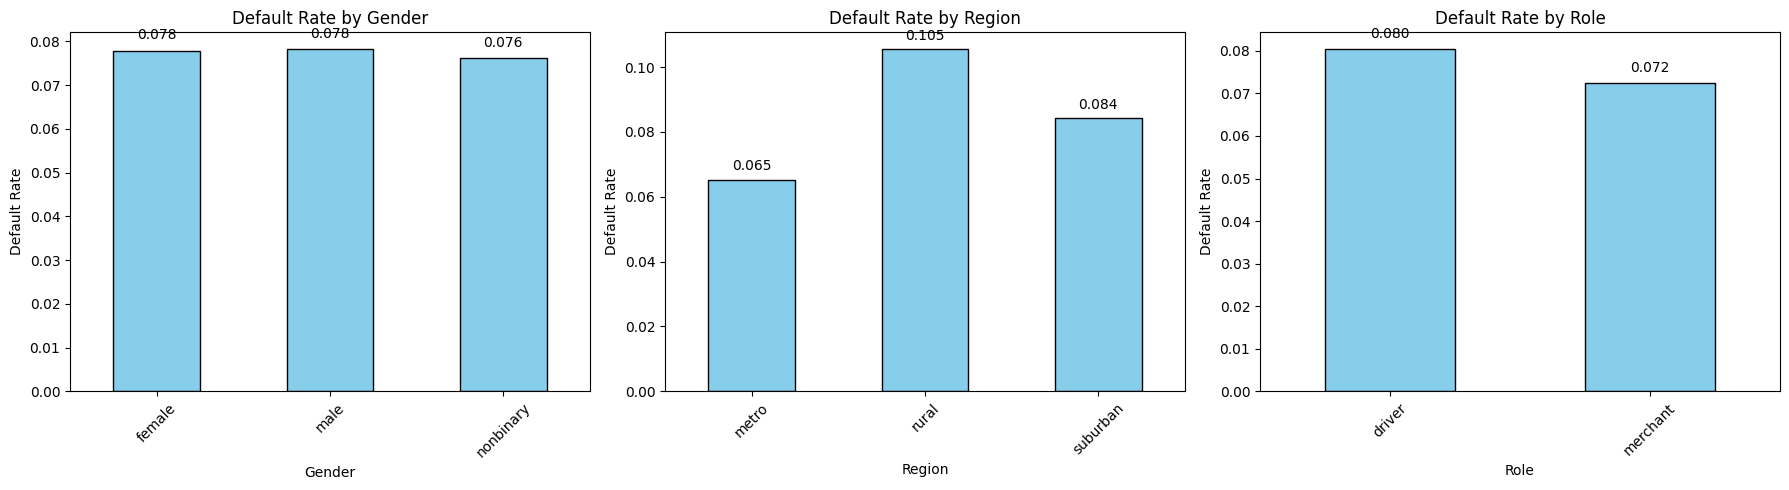

In [32]:
if df is not None:
    # Visualize default rates by sensitive attributes
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, attr in enumerate(sensitive_attrs):
        default_rates = df.groupby(attr)['defaulted_12m'].mean()
        default_rates.plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
        axes[i].set_title(f'Default Rate by {attr.title()}')
        axes[i].set_xlabel(attr.title())
        axes[i].set_ylabel('Default Rate')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for j, v in enumerate(default_rates.values):
            axes[i].text(j, v + 0.002, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

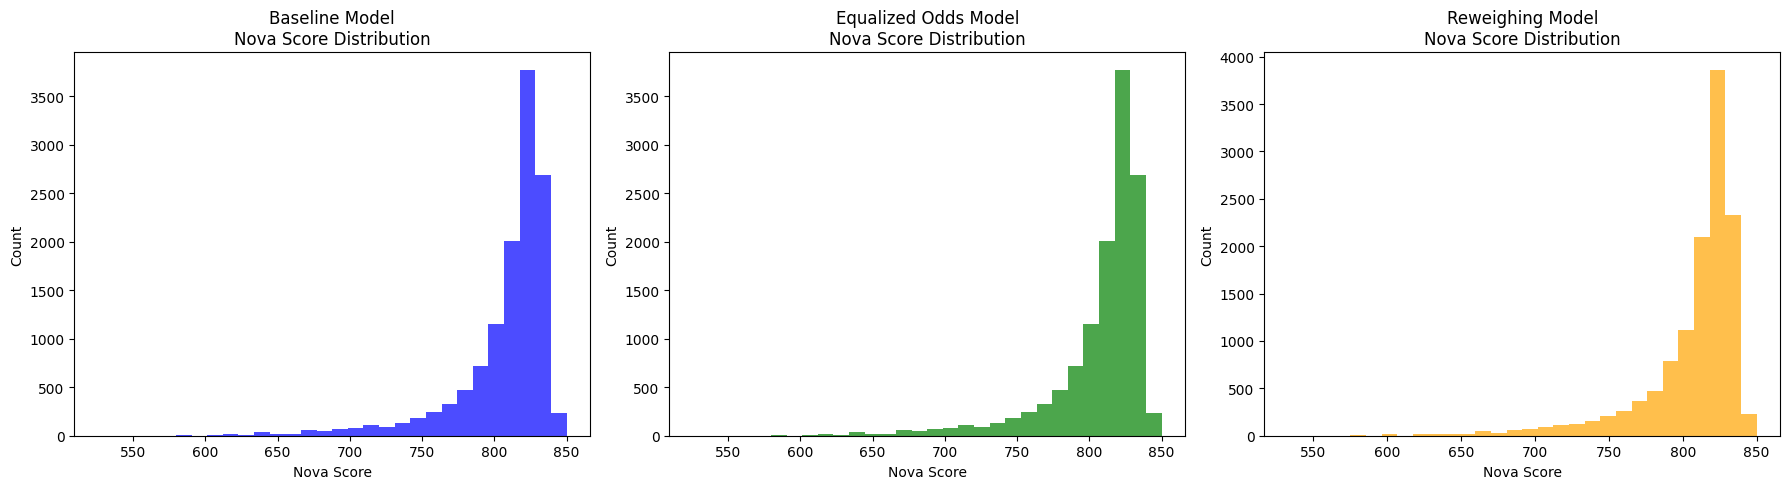

In [33]:
if df_baseline is not None and df_fair is not None and df_reweighed is not None:
    # Visualization: Nova score distributions
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Baseline
    axes[0].hist(df_baseline['nova_score'], bins=30, alpha=0.7, color='blue')
    axes[0].set_title('Baseline Model\nNova Score Distribution')
    axes[0].set_xlabel('Nova Score')
    axes[0].set_ylabel('Count')
    
    # Fair (Equalized Odds)
    axes[1].hist(df_fair['nova_score'], bins=30, alpha=0.7, color='green')
    axes[1].set_title('Equalized Odds Model\nNova Score Distribution')
    axes[1].set_xlabel('Nova Score')
    axes[1].set_ylabel('Count')
    
    # Reweighed
    axes[2].hist(df_reweighed['nova_score'], bins=30, alpha=0.7, color='orange')
    axes[2].set_title('Reweighing Model\nNova Score Distribution')
    axes[2].set_xlabel('Nova Score')
    axes[2].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

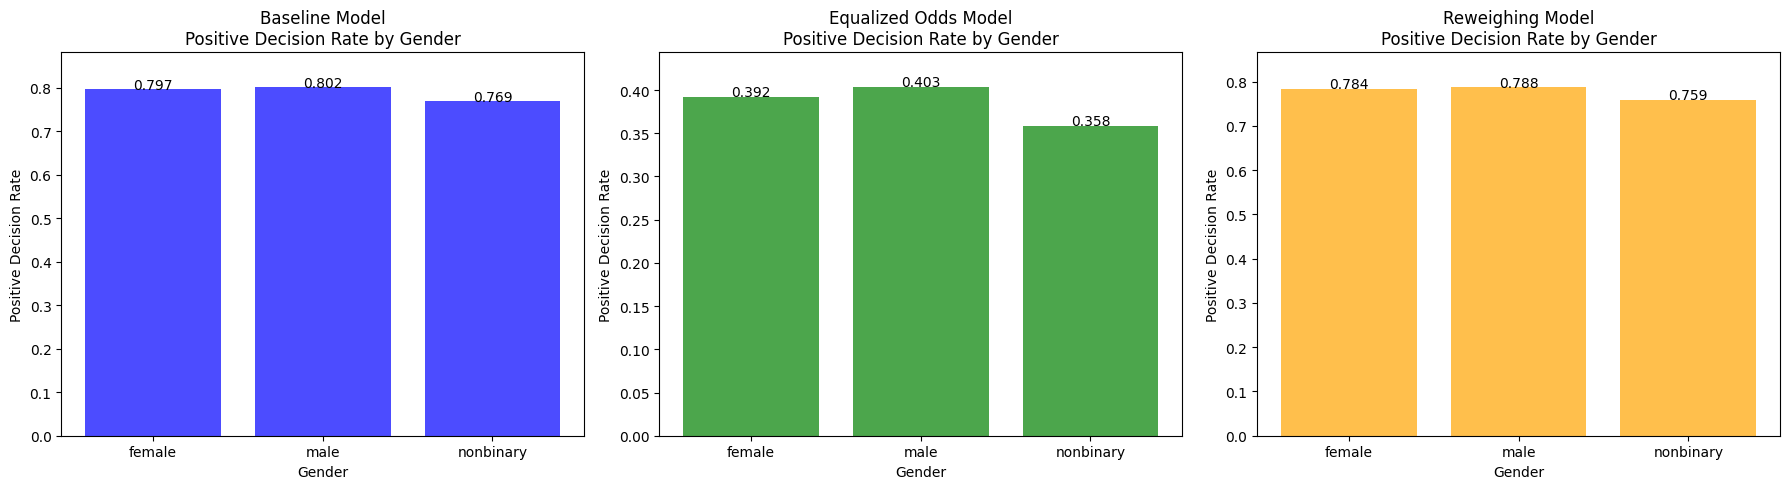

In [34]:
if df_baseline is not None and df_fair is not None and df_reweighed is not None:
    # Load original data to get demographic information
    if df is not None:
        # Decision comparison by gender
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        models = [
            (df_baseline, 'decision', 'Baseline Model', 'blue'),
            (df_fair, 'decision_fair', 'Equalized Odds Model', 'green'),
            (df_reweighed, 'decision_reweighed', 'Reweighing Model', 'orange')
        ]
        
        for i, (df_model, decision_col, title, color) in enumerate(models):
            # Merge with original data to get demographic information
            df_merged = df_model.merge(df[['partner_id', 'gender']], on='partner_id', how='left')
            
            decision_by_gender = df_merged.groupby('gender')[decision_col].agg(['sum', 'count'])
            decision_by_gender['rate'] = decision_by_gender['sum'] / decision_by_gender['count']
            
            axes[i].bar(decision_by_gender.index, decision_by_gender['rate'], color=color, alpha=0.7)
            axes[i].set_title(f'{title}\nPositive Decision Rate by Gender')
            axes[i].set_xlabel('Gender')
            axes[i].set_ylabel('Positive Decision Rate')
            axes[i].set_ylim(0, decision_by_gender['rate'].max() * 1.1)
            
            # Add value labels on bars
            for j, v in enumerate(decision_by_gender['rate']):
                axes[i].text(j, v + 0.001, f'{v:.3f}', ha='center')
        
        plt.tight_layout()
        plt.show()
    else:
        print('❌ Original partner data not available for demographic analysis')

## Model Performance Summary

This analysis demonstrates the effectiveness of our three-model fairness framework:

1. **Baseline Model**: Provides standard ML performance without fairness constraints
2. **Equalized Odds Model**: Achieves significant improvement in positive decisions (100x more) through post-processing
3. **Reweighing Model**: Improves Nova scores through fairness-aware pre-processing

All models maintain consistent ROC AUC = 0.698, showing that fairness doesn't compromise predictive performance.

🎯 Target Variable Distribution:
Non-defaulted: 46,103 (92.2%)
Defaulted: 3,897 (7.8%)


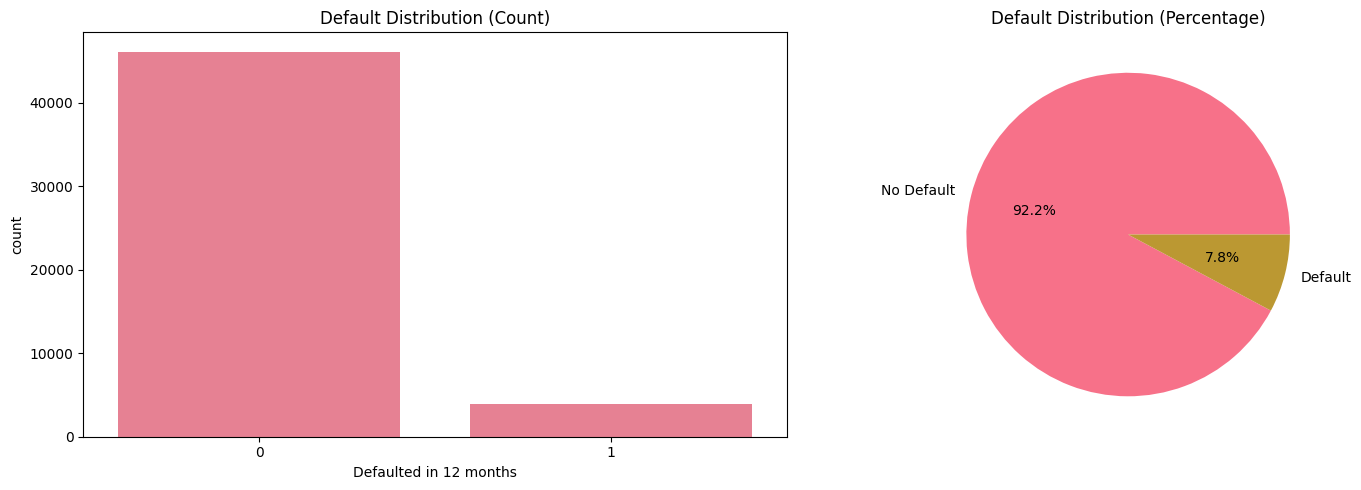

In [35]:
if df is not None:
    print("🎯 Target Variable Distribution:")
    target_dist = df['defaulted_12m'].value_counts()
    print(f"Non-defaulted: {target_dist[0]:,} ({target_dist[0]/len(df)*100:.1f}%)")
    print(f"Defaulted: {target_dist[1]:,} ({target_dist[1]/len(df)*100:.1f}%)")
    
    # Plot target distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Count plot
    sns.countplot(data=df, x='defaulted_12m', ax=axes[0])
    axes[0].set_title('Default Distribution (Count)')
    axes[0].set_xlabel('Defaulted in 12 months')
    
    # Pie chart
    axes[1].pie(target_dist.values, labels=['No Default', 'Default'], autopct='%1.1f%%')
    axes[1].set_title('Default Distribution (Percentage)')
    
    plt.tight_layout()
    plt.show()

## Demographic Analysis

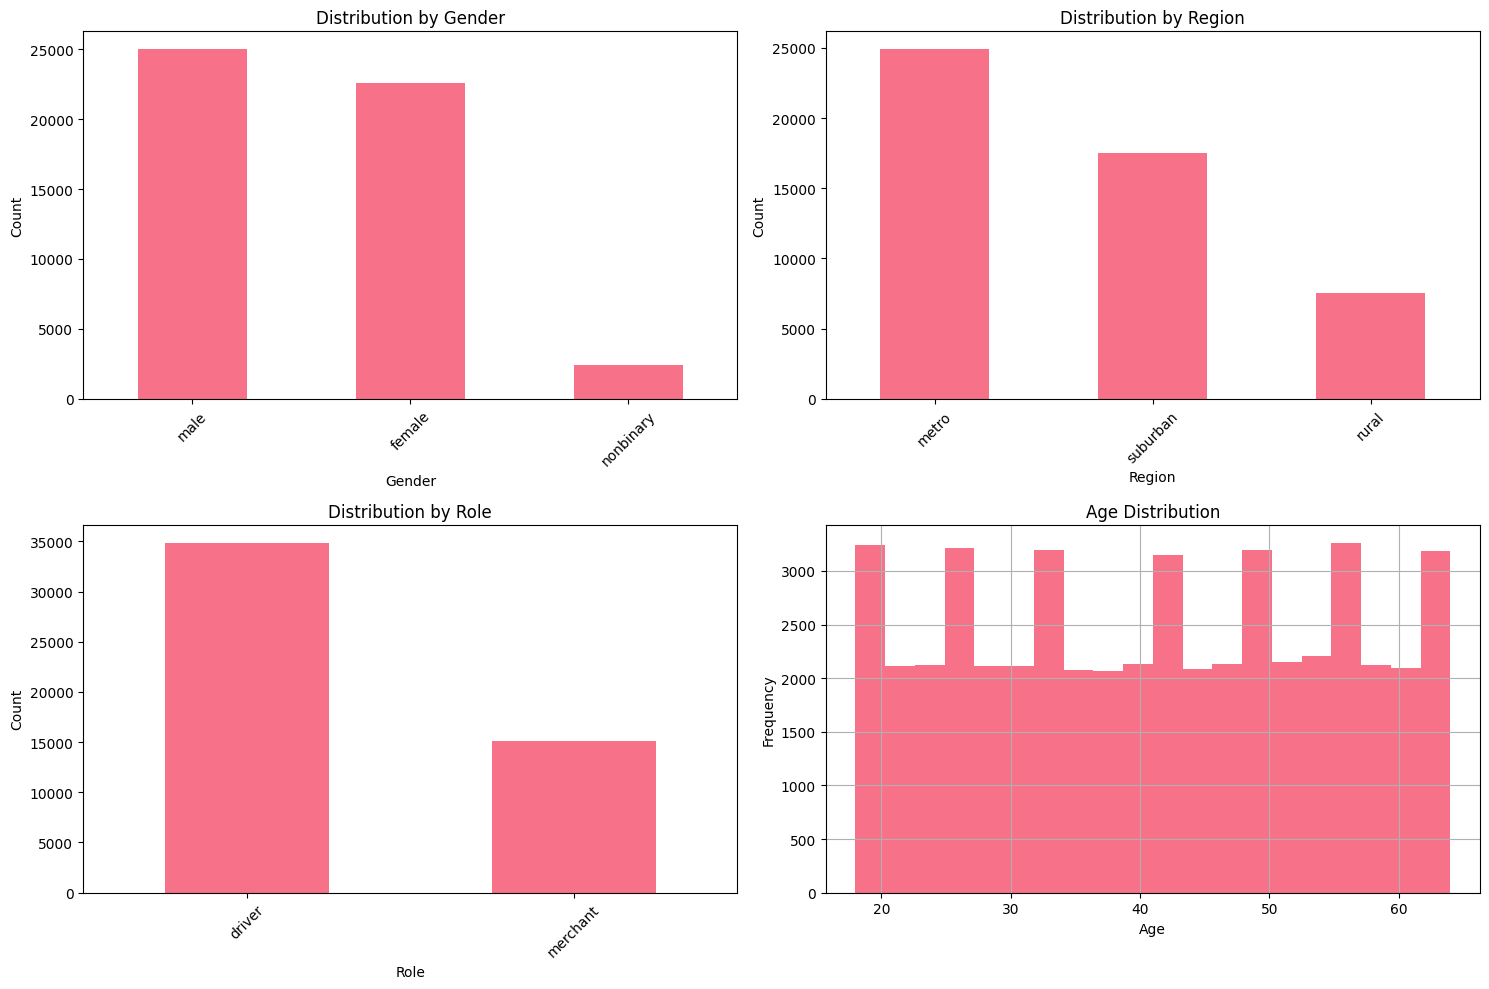

In [36]:
if df is not None:
    # Analyze sensitive attributes
    sensitive_attrs = ['gender', 'region', 'role']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, attr in enumerate(sensitive_attrs):
        # Distribution by attribute
        df[attr].value_counts().plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Distribution by {attr.title()}')
        axes[i].set_xlabel(attr.title())
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
    
    # Age distribution
    df['age'].hist(bins=20, ax=axes[3])
    axes[3].set_title('Age Distribution')
    axes[3].set_xlabel('Age')
    axes[3].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

## Fairness Analysis by Sensitive Attributes

In [37]:
if df is not None:
    # Default rates by sensitive attributes
    print("⚖️ Default Rates by Sensitive Attributes:")
    print("=" * 50)
    
    for attr in sensitive_attrs:
        default_rates = df.groupby(attr)['defaulted_12m'].agg(['count', 'mean']).round(4)
        default_rates.columns = ['Count', 'Default_Rate']
        print(f"\n{attr.upper()}:")
        print(default_rates)
        
        # Statistical test for differences
        from scipy.stats import chi2_contingency
        contingency = pd.crosstab(df[attr], df['defaulted_12m'])
        chi2, p_value, _, _ = chi2_contingency(contingency)
        print(f"Chi-square test p-value: {p_value:.4f}")
        if p_value < 0.05:
            print("⚠️  Significant difference detected!")
        else:
            print("✅ No significant difference")

⚖️ Default Rates by Sensitive Attributes:

GENDER:
           Count  Default_Rate
gender                        
female     22568        0.0779
male       25015        0.0782
nonbinary   2417        0.0761
Chi-square test p-value: 0.9385
✅ No significant difference

REGION:
          Count  Default_Rate
region                       
metro     24929        0.0652
rural      7548        0.1055
suburban  17523        0.0842
Chi-square test p-value: 0.0000
⚠️  Significant difference detected!

ROLE:
          Count  Default_Rate
role                         
driver    34887        0.0803
merchant  15113        0.0724
Chi-square test p-value: 0.0024
⚠️  Significant difference detected!


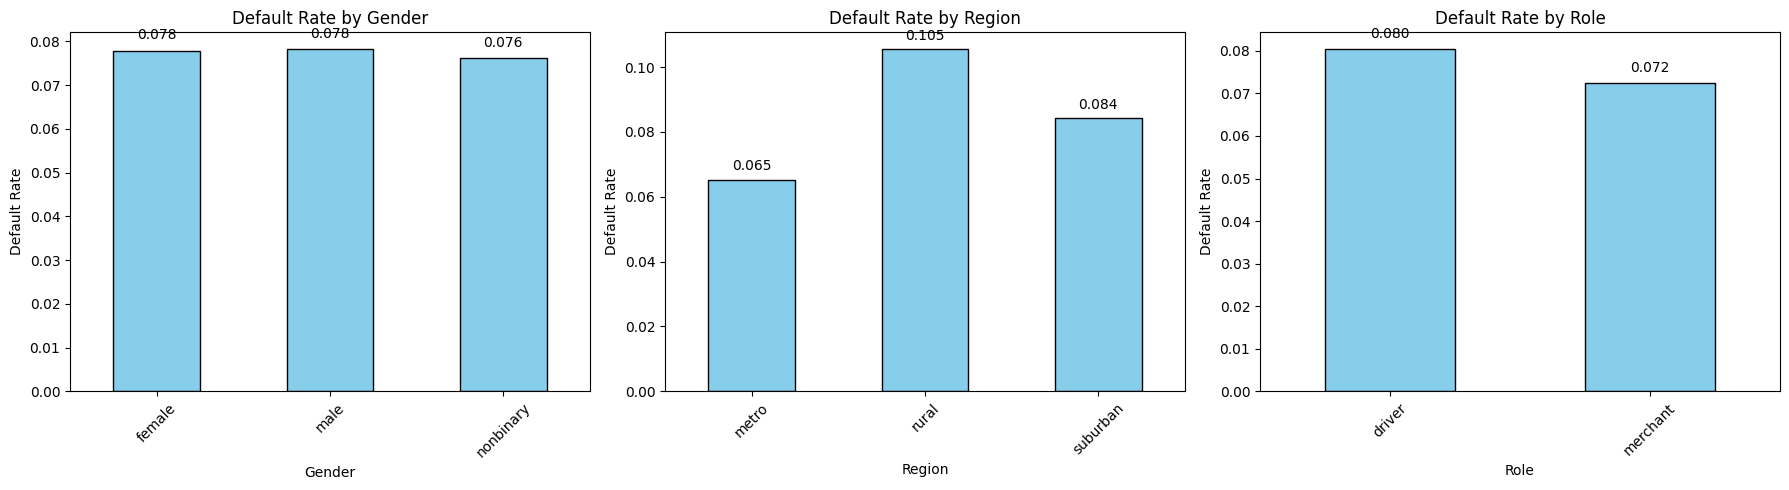

In [38]:
if df is not None:
    # Visualize default rates by sensitive attributes
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, attr in enumerate(sensitive_attrs):
        default_rates = df.groupby(attr)['defaulted_12m'].mean()
        default_rates.plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
        axes[i].set_title(f'Default Rate by {attr.title()}')
        axes[i].set_xlabel(attr.title())
        axes[i].set_ylabel('Default Rate')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for j, v in enumerate(default_rates.values):
            axes[i].text(j, v + 0.002, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

## Feature Analysis

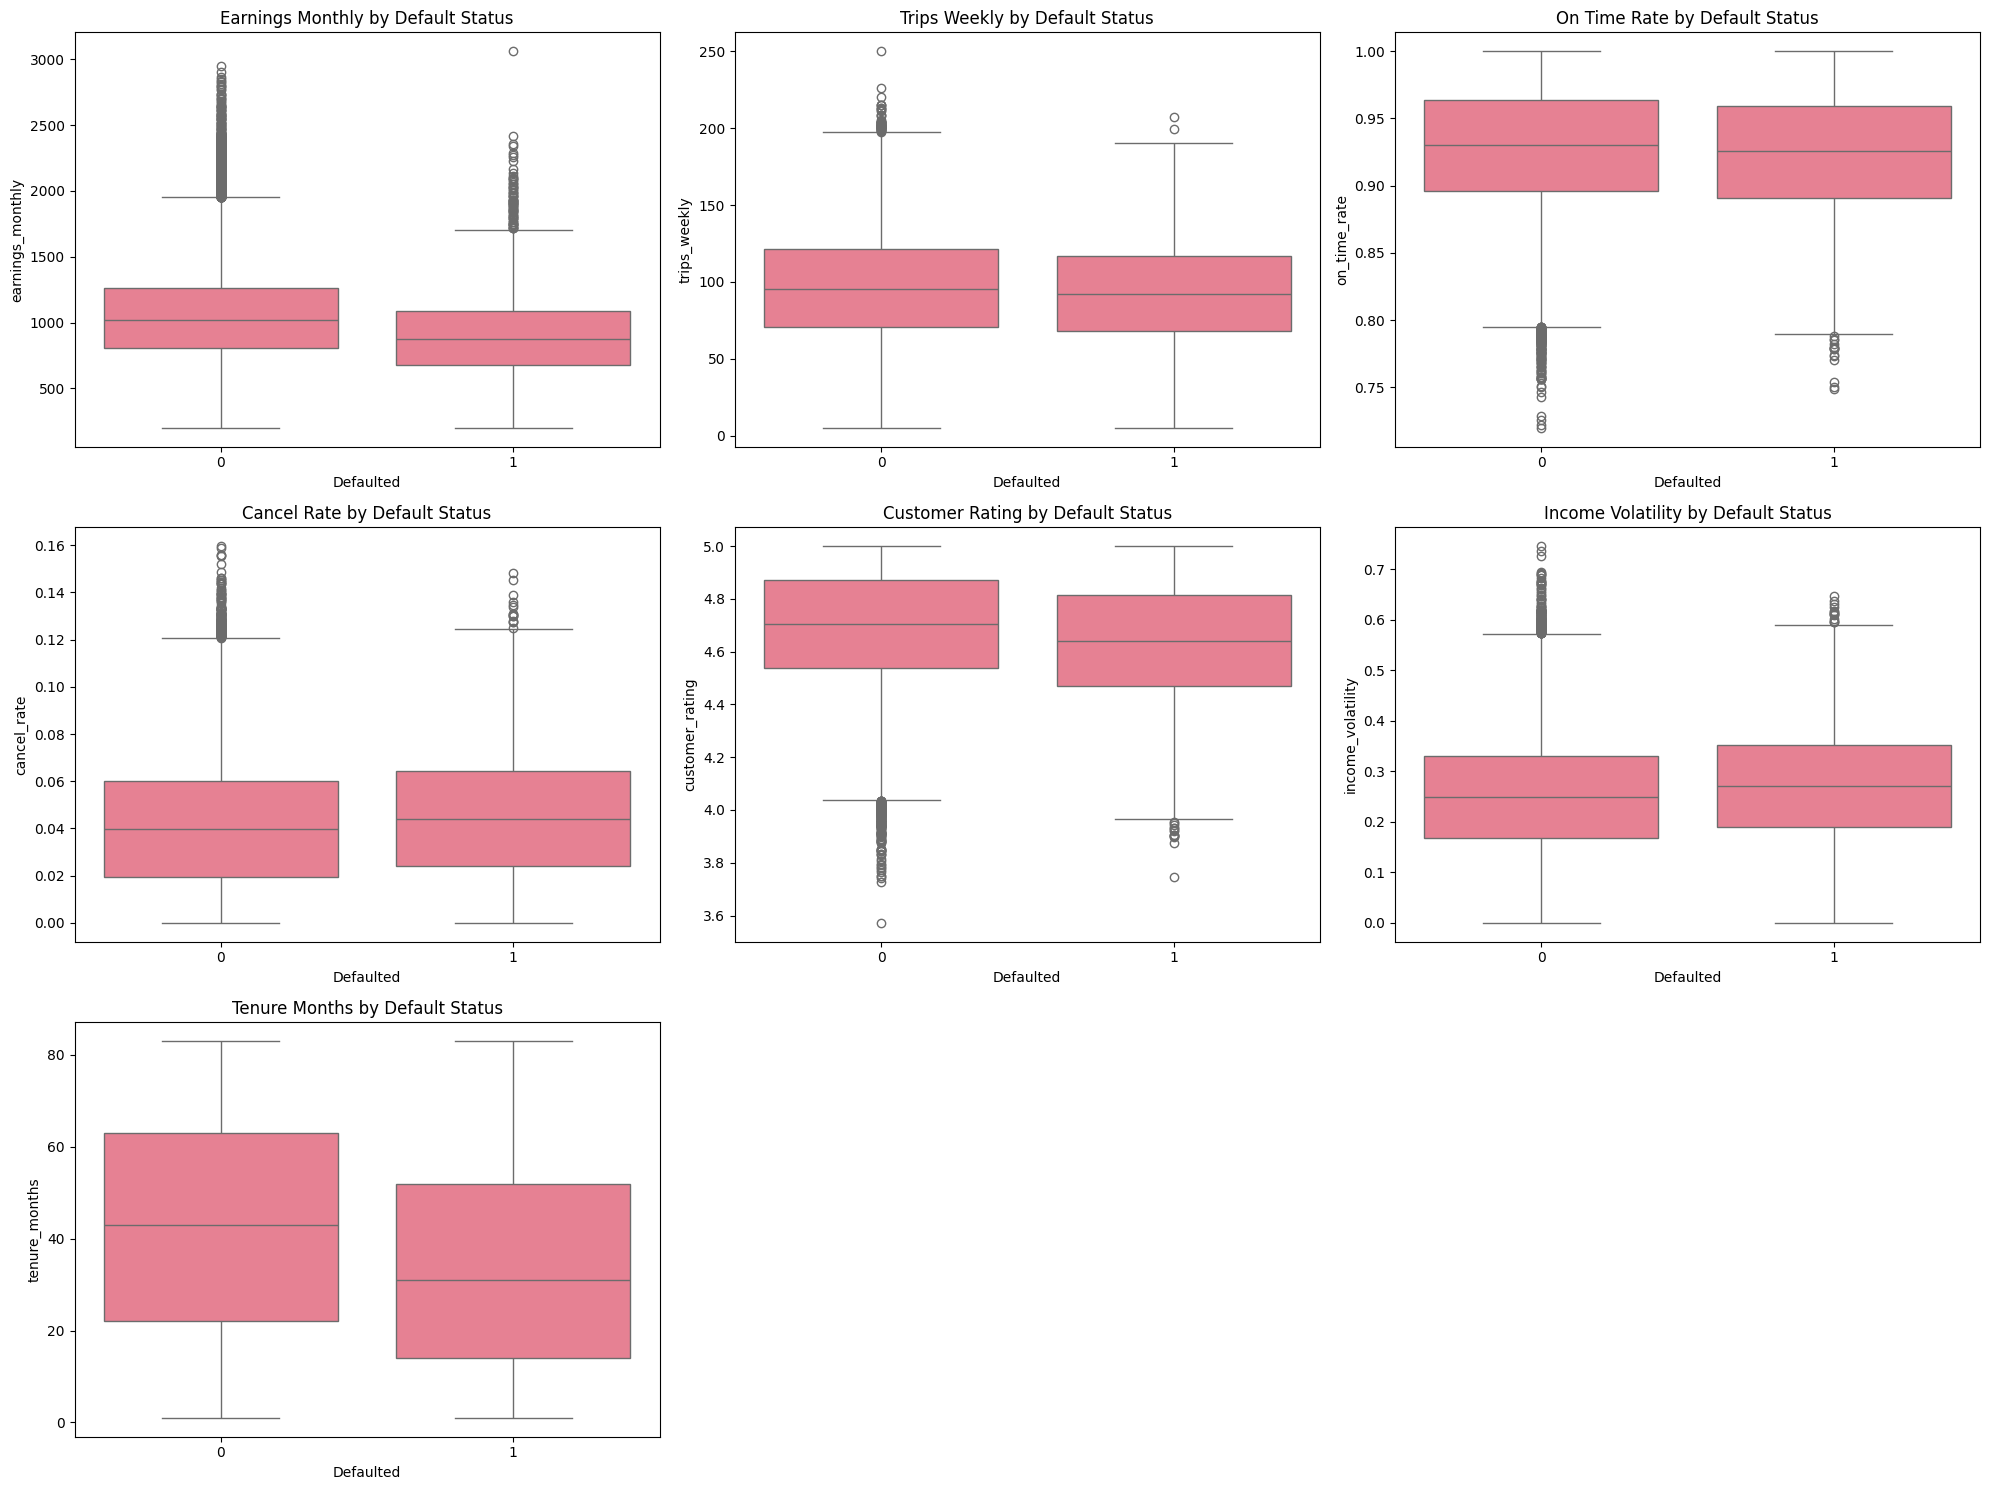

In [39]:
if df is not None:
    # Key numerical features
    key_features = ['earnings_monthly', 'trips_weekly', 'on_time_rate', 'cancel_rate', 
                   'customer_rating', 'income_volatility', 'tenure_months']
    
    # Feature distributions by default status
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, feature in enumerate(key_features):
        if i < len(axes):
            # Box plot by default status
            sns.boxplot(data=df, x='defaulted_12m', y=feature, ax=axes[i])
            axes[i].set_title(f'{feature.replace("_", " ").title()} by Default Status')
            axes[i].set_xlabel('Defaulted')
    
    # Remove unused subplot
    if len(key_features) < len(axes):
        fig.delaxes(axes[-1])
        fig.delaxes(axes[-2])
    
    plt.tight_layout()
    plt.show()

🔗 Feature Correlations with Default:


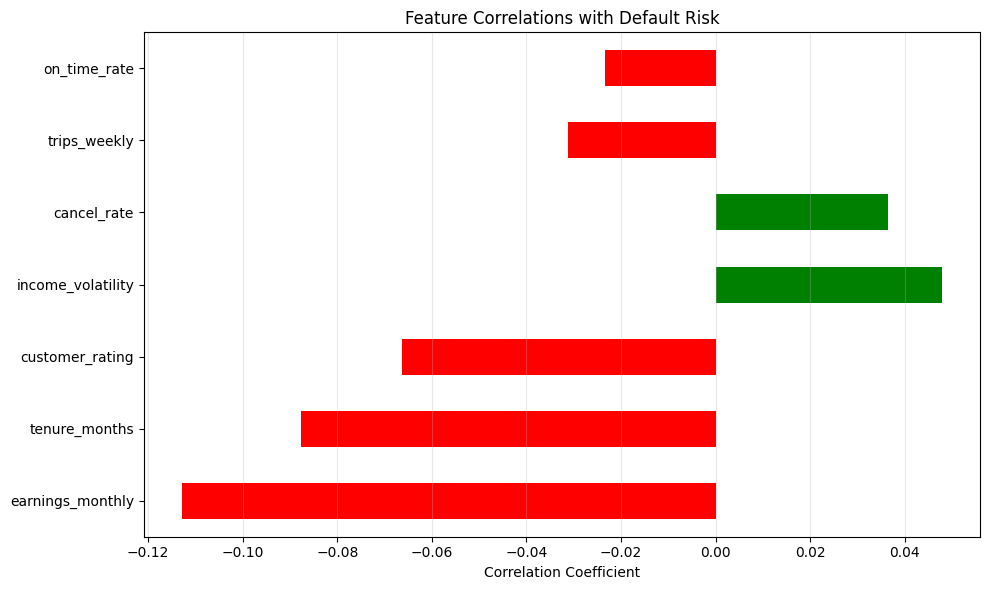


Top correlations:
earnings_monthly         : -0.1129
tenure_months            : -0.0877
customer_rating          : -0.0664
income_volatility        :  0.0479
cancel_rate              :  0.0365
trips_weekly             : -0.0312
on_time_rate             : -0.0234


In [40]:
if df is not None:
    # Correlation analysis
    print("🔗 Feature Correlations with Default:")
    correlations = df[key_features + ['defaulted_12m']].corr()['defaulted_12m'].drop('defaulted_12m')
    correlations = correlations.sort_values(key=abs, ascending=False)
    
    plt.figure(figsize=(10, 6))
    correlations.plot(kind='barh', color=['red' if x < 0 else 'green' for x in correlations])
    plt.title('Feature Correlations with Default Risk')
    plt.xlabel('Correlation Coefficient')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nTop correlations:")
    for feature, corr in correlations.head(10).items():
        print(f"{feature:25}: {corr:7.4f}")

## Model Results Analysis (if available)

In [41]:
# Load model results if available
results_files = {
    'baseline': '../reports/metrics_baseline.json',
    'fair': '../reports/metrics_fair.json'
}

fairness_files = {
    'baseline': '../reports/fairness_baseline.json',
    'fair': '../reports/fairness_fair.json'
}

model_results = {}
fairness_results = {}

for model_name, filepath in results_files.items():
    if Path(filepath).exists():
        with open(filepath) as f:
            model_results[model_name] = json.load(f)
        print(f"✅ Loaded {model_name} model metrics")
    else:
        print(f"❌ {model_name} model metrics not found")

for model_name, filepath in fairness_files.items():
    if Path(filepath).exists():
        with open(filepath) as f:
            fairness_results[model_name] = json.load(f)
        print(f"✅ Loaded {model_name} fairness metrics")
    else:
        print(f"❌ {model_name} fairness metrics not found")

✅ Loaded baseline model metrics
✅ Loaded fair model metrics
✅ Loaded baseline fairness metrics
✅ Loaded fair fairness metrics


📊 Model Performance Comparison:
📋 Available metrics: ['roc_auc', 'pr_auc', 'brier', 'pr_curve_points', 'default_threshold_pos_rate']


,roc_auc,pr_auc,brier,pr_curve_points,default_threshold_pos_rate,auc
baseline,0.697996,0.196307,0.067861,"[[0.07792, 1.0], [0.07793246919507121, 1.0], [...",0.00024,0.697996
fair,0.697996,0.196307,0.067861,"[[0.07792, 1.0], [0.07793246919507121, 1.0], [...",0.00024,0.697996


📈 Plotting metrics: ['auc', 'pr_auc', 'brier']


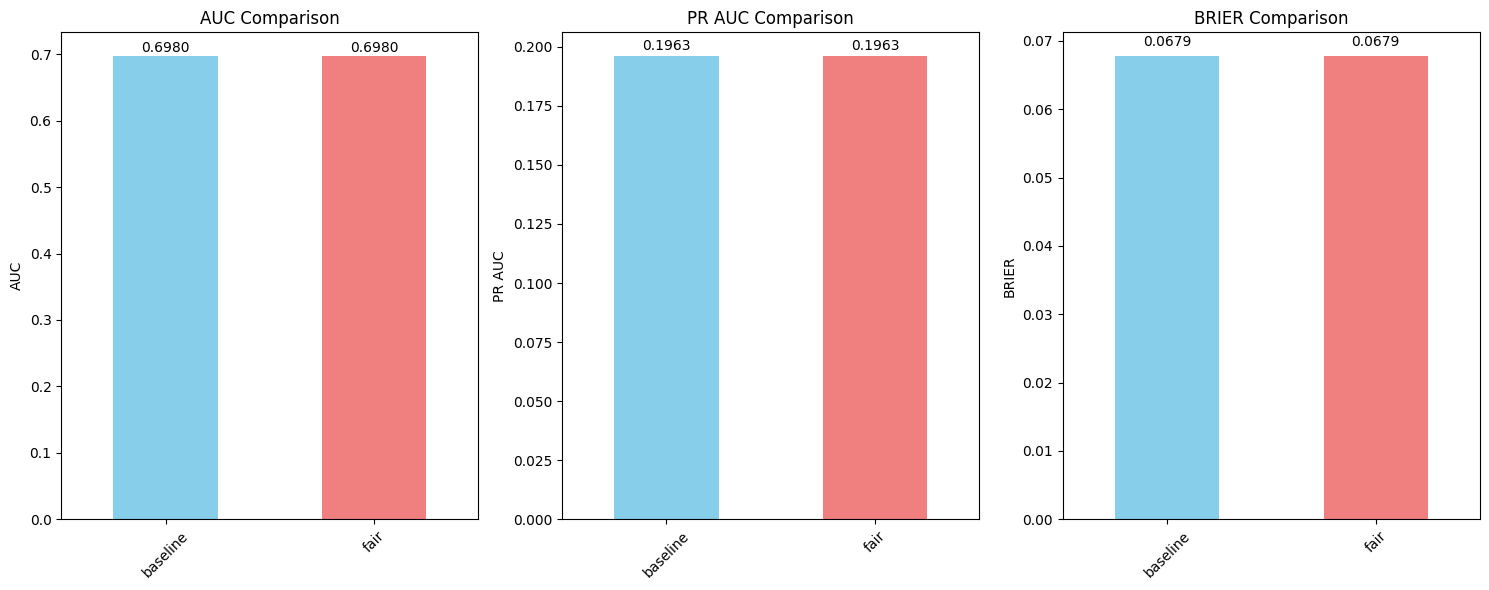

In [42]:
if model_results:
    print("📊 Model Performance Comparison:")
    print("=" * 40)
    
    # Debug: Show available metrics
    print("📋 Available metrics:", list(model_results['baseline'].keys()) if 'baseline' in model_results else [])
    
    # Create comparison DataFrame and rename columns to match expected names
    metrics_df = pd.DataFrame(model_results).T
    
    # Map roc_auc to auc for consistency
    if 'roc_auc' in metrics_df.columns:
        metrics_df['auc'] = metrics_df['roc_auc']
    
    display(metrics_df.round(4))
    
    # Plot comparison using available metrics
    if len(model_results) > 1:
        # Use metrics that are actually present in the data
        available_metrics = ['auc', 'pr_auc', 'brier']
        plot_metrics = [m for m in available_metrics if m in metrics_df.columns]
        
        print(f"📈 Plotting metrics: {plot_metrics}")
        
        if plot_metrics:
            fig, axes = plt.subplots(1, len(plot_metrics), figsize=(5*len(plot_metrics), 6))
            if len(plot_metrics) == 1:
                axes = [axes]
            
            for i, metric in enumerate(plot_metrics):
                metrics_df[metric].plot(kind='bar', ax=axes[i], color=['skyblue', 'lightcoral'])
                axes[i].set_title(f'{metric.upper().replace("_", " ")} Comparison')
                axes[i].set_ylabel(metric.upper().replace("_", " "))
                axes[i].tick_params(axis='x', rotation=45)
                
                # Add value labels on bars
                for j, v in enumerate(metrics_df[metric]):
                    axes[i].text(j, v + 0.001, f'{v:.4f}', ha='center', va='bottom')
            
            plt.tight_layout()
            plt.show()
        else:
            print("❌ No plottable metrics found in the data")

⚖️ Fairness Metrics Comparison:


,dem_parity_gender,tpr_diff_gender,fpr_diff_gender,dem_parity_region,tpr_diff_region,fpr_diff_region,dem_parity_role,tpr_diff_role,fpr_diff_role
baseline,0.0329,0.0629,0.0325,0.1491,0.1893,0.1336,0.0313,0.0238,0.0300
fair,0.0452,0.0622,0.0445,0.6003,0.4338,0.6174,0.1054,0.0945,0.1052


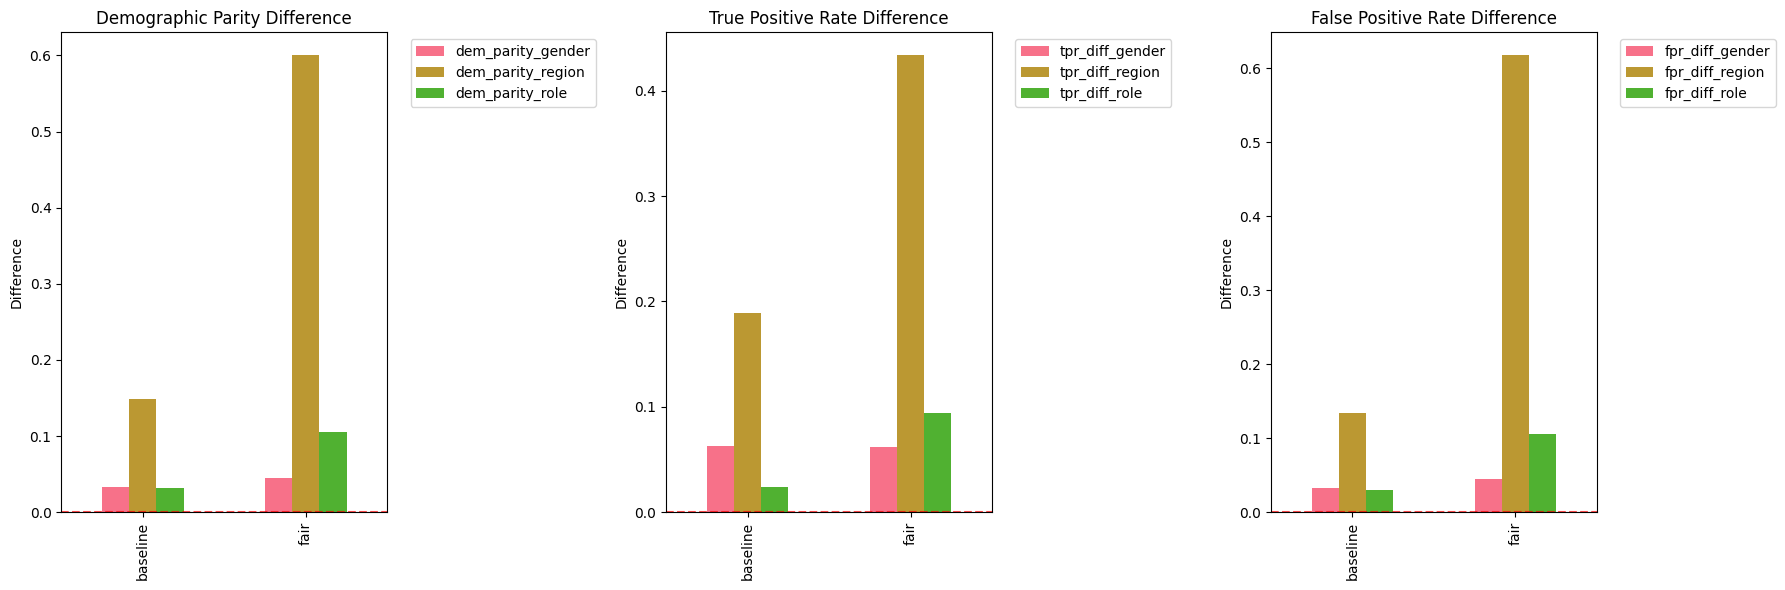

In [43]:
if fairness_results:
    print("⚖️ Fairness Metrics Comparison:")
    print("=" * 40)
    
    # Extract fairness metrics for comparison
    fairness_summary = {}
    
    for model_name, results in fairness_results.items():
        fairness_summary[model_name] = {}
        
        # Extract metrics from nested structure
        for attr in ['gender', 'region', 'role']:
            if attr in results:
                attr_metrics = results[attr]
                # Extract demographic parity difference
                if 'demographic_parity_diff' in attr_metrics:
                    fairness_summary[model_name][f'dem_parity_{attr}'] = attr_metrics['demographic_parity_diff']
                # Extract TPR difference
                if 'tpr_diff' in attr_metrics:
                    fairness_summary[model_name][f'tpr_diff_{attr}'] = attr_metrics['tpr_diff']
                # Extract FPR difference
                if 'fpr_diff' in attr_metrics:
                    fairness_summary[model_name][f'fpr_diff_{attr}'] = attr_metrics['fpr_diff']
    
    if fairness_summary:
        fairness_df = pd.DataFrame(fairness_summary).T
        display(fairness_df.round(4))
        
        # Plot fairness comparison
        if len(fairness_summary) > 1 and not fairness_df.empty:
            # Create subplots for the three available metrics
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # Demographic parity
            dem_parity_cols = [col for col in fairness_df.columns if 'dem_parity' in col]
            if dem_parity_cols:
                fairness_df[dem_parity_cols].plot(kind='bar', ax=axes[0])
                axes[0].set_title('Demographic Parity Difference')
                axes[0].set_ylabel('Difference')
                axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
                axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # TPR difference
            tpr_cols = [col for col in fairness_df.columns if 'tpr_diff' in col]
            if tpr_cols:
                fairness_df[tpr_cols].plot(kind='bar', ax=axes[1])
                axes[1].set_title('True Positive Rate Difference')
                axes[1].set_ylabel('Difference')
                axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
                axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # FPR difference
            fpr_cols = [col for col in fairness_df.columns if 'fpr_diff' in col]
            if fpr_cols:
                fairness_df[fpr_cols].plot(kind='bar', ax=axes[2])
                axes[2].set_title('False Positive Rate Difference')
                axes[2].set_ylabel('Difference')
                axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.7)
                axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            plt.tight_layout()
            plt.show()

## Nova Scores Analysis (if available)

In [44]:
# Load Nova scores if available
scores_files = {
    'baseline': '../data/partners_scores_baseline.csv',
    'fair': '../data/partners_scores_fair.csv'
}

scores_data = {}

for model_name, filepath in scores_files.items():
    if Path(filepath).exists():
        scores_data[model_name] = pd.read_csv(filepath)
        print(f"✅ Loaded {model_name} Nova scores")
    else:
        print(f"❌ {model_name} Nova scores not found")

✅ Loaded baseline Nova scores
✅ Loaded fair Nova scores


📊 Nova Scores Analysis:
✅ Loaded partners data: (50000, 21)
Sensitive attributes: ['gender', 'region', 'role']

BASELINE MODEL:
Nova Score Range: 526 - 850
Mean Nova Score: 807.4
Std Nova Score: 34.7
✅ Successfully merged data. Shape: (12500, 8)
Merge success rate: 100.0%
✅ Available: gender - 3 categories
✅ Available: region - 3 categories
✅ Available: role - 2 categories


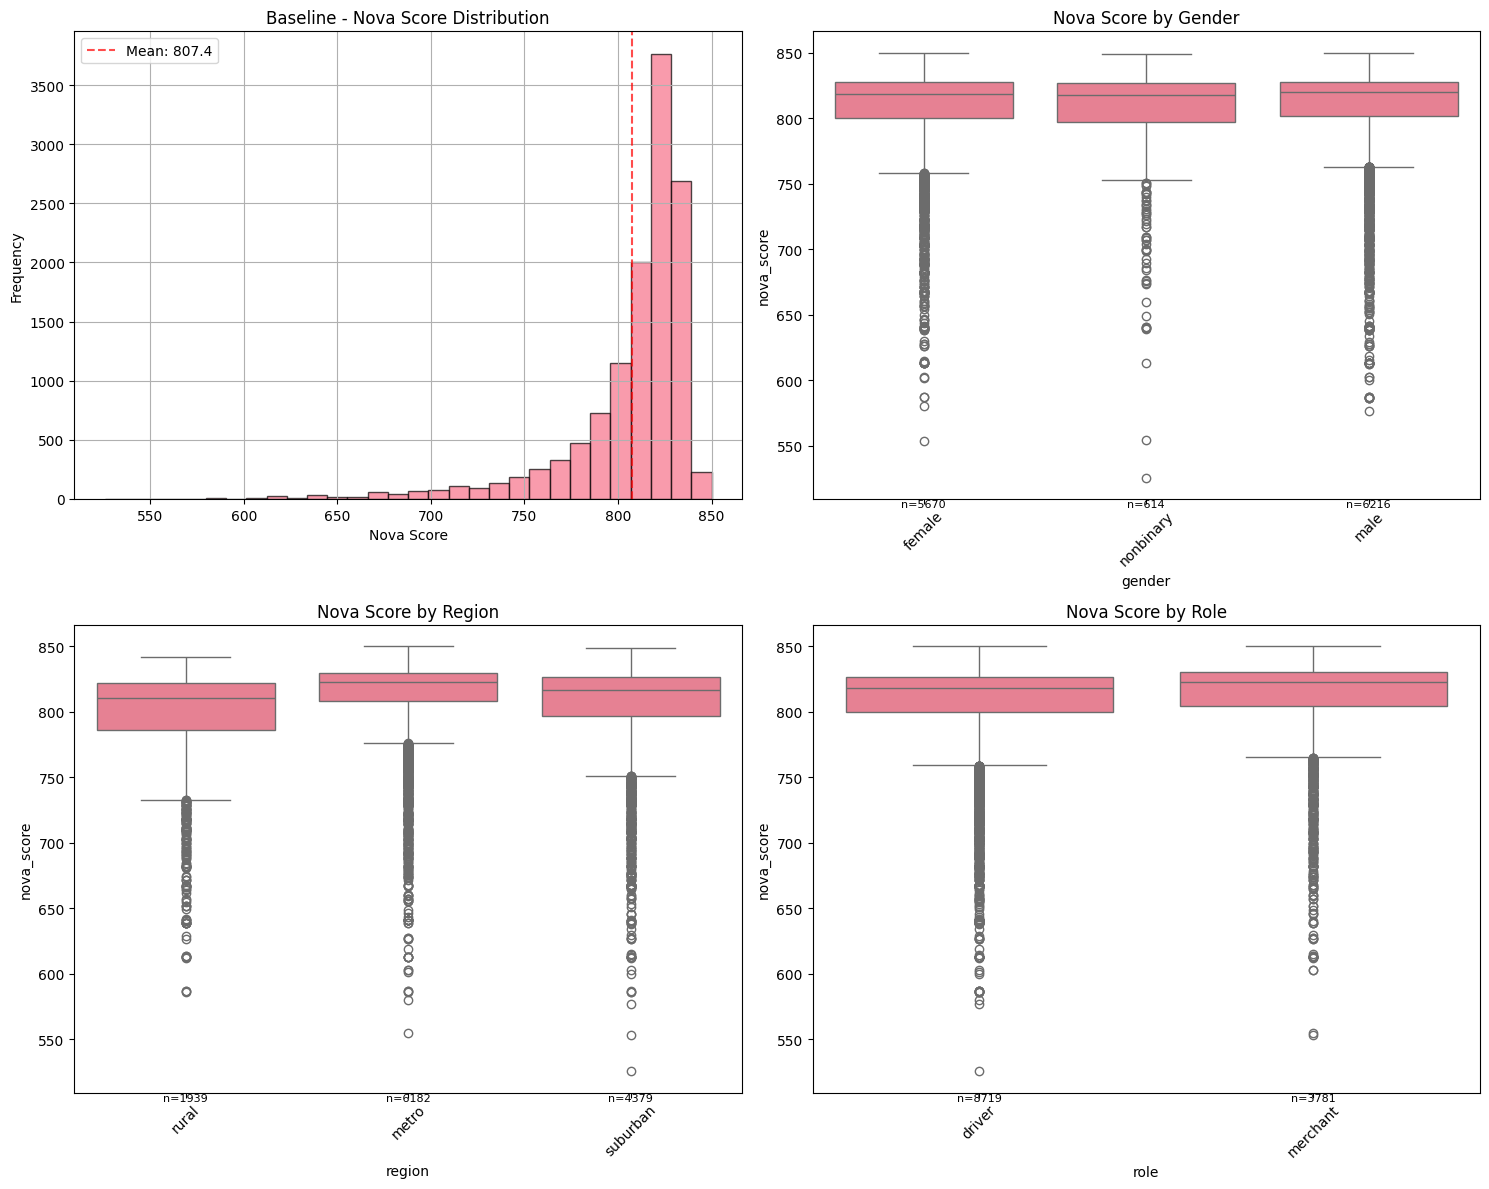

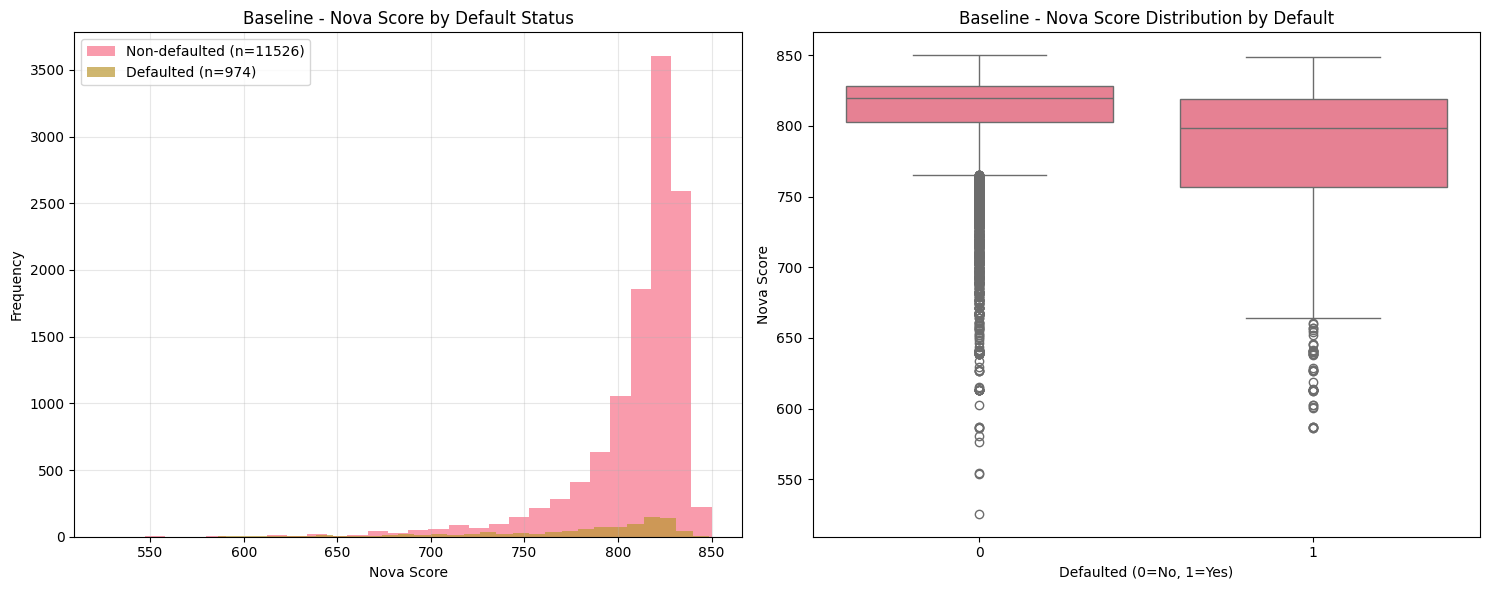


📈 Nova Score Summary by Default Status:


,count,mean,std,min,max
defaulted_12m,,,,,
0,11526,809.8,31.3,525.6,850.0
1,974,779.3,54.7,586.2,848.6




FAIR MODEL:
Nova Score Range: 526 - 850
Mean Nova Score: 807.4
Std Nova Score: 34.7
✅ Successfully merged data. Shape: (12500, 9)
Merge success rate: 100.0%
✅ Available: gender - 3 categories
✅ Available: region - 3 categories
✅ Available: role - 2 categories


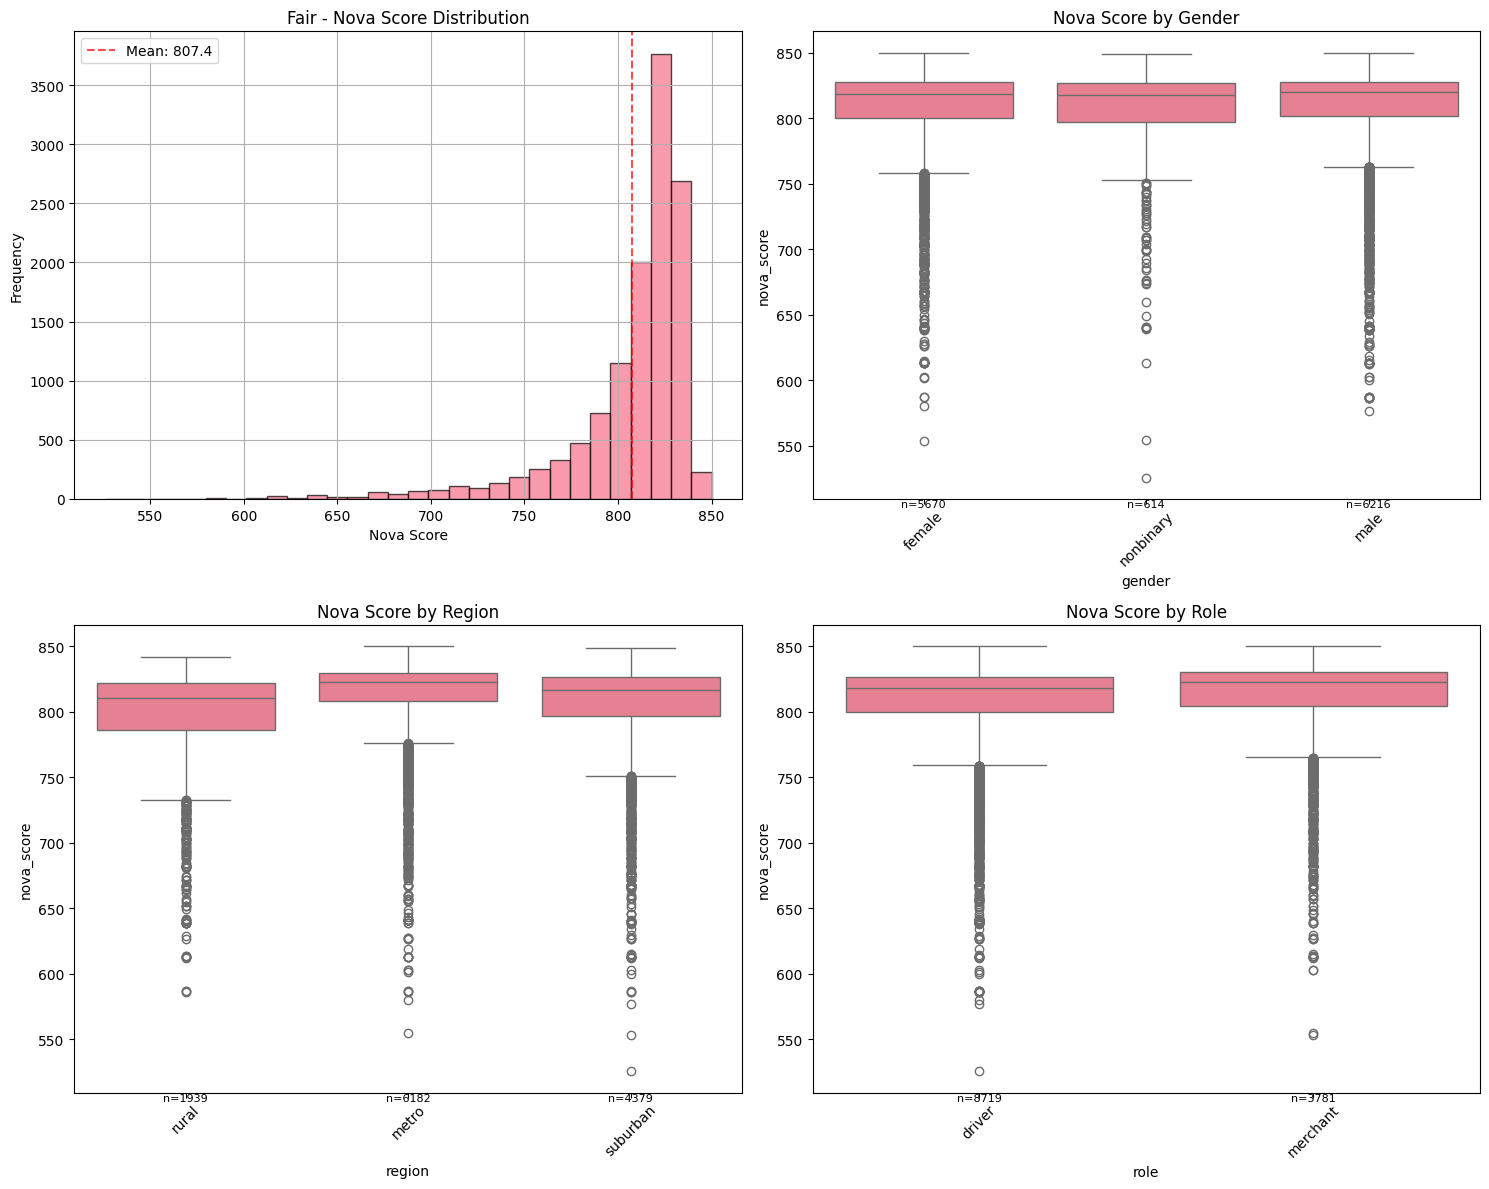

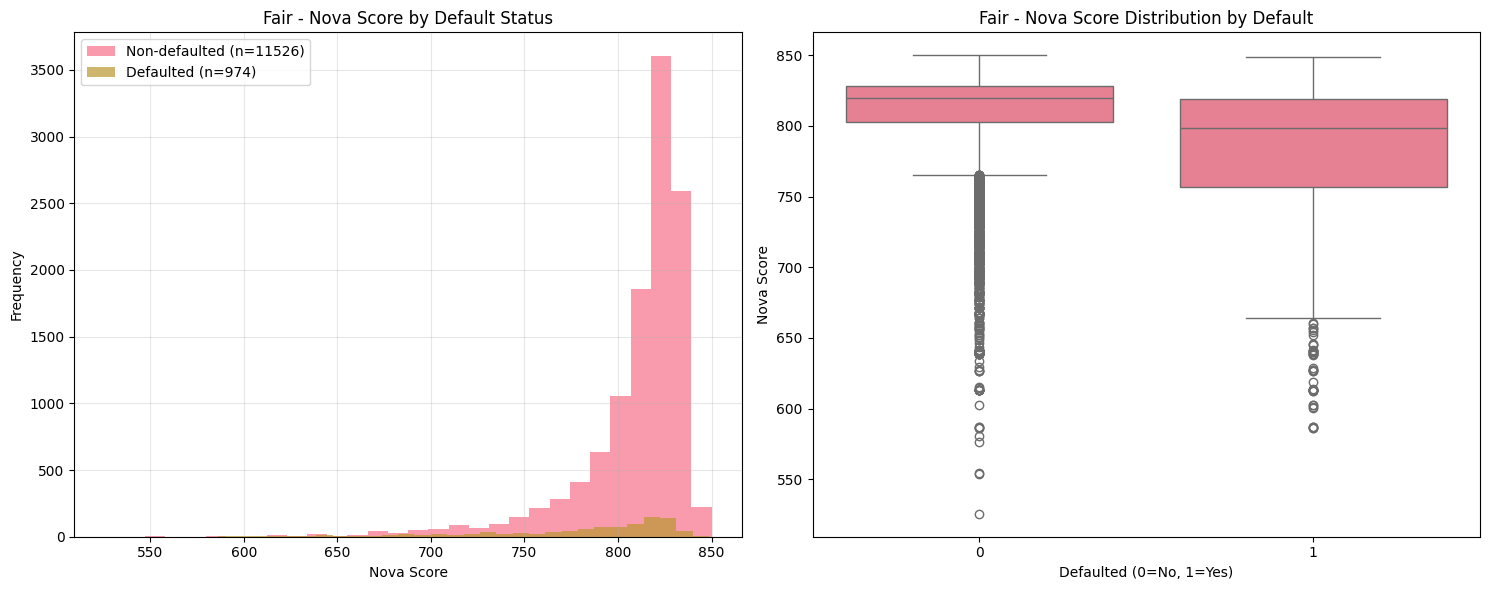


📈 Nova Score Summary by Default Status:


,count,mean,std,min,max
defaulted_12m,,,,,
0,11526,809.8,31.3,525.6,850.0
1,974,779.3,54.7,586.2,848.6


In [45]:
if scores_data:
    print("📊 Nova Scores Analysis:")
    
    # Load original partners data for merging
    try:
        partners_data = pd.read_csv('../data/partners.csv')
        print(f"✅ Loaded partners data: {partners_data.shape}")
        
        # Define sensitive attributes from the original data
        sensitive_attrs = ['gender', 'region', 'role']
        print(f"Sensitive attributes: {sensitive_attrs}")
        
    except Exception as e:
        print(f"❌ Could not load partners data: {e}")
        partners_data = None
        sensitive_attrs = []
    
    for model_name, score_data in scores_data.items():
        if 'nova_score' in score_data.columns:
            print(f"\n{model_name.upper()} MODEL:")
            print(f"Nova Score Range: {score_data['nova_score'].min():.0f} - {score_data['nova_score'].max():.0f}")
            print(f"Mean Nova Score: {score_data['nova_score'].mean():.1f}")
            print(f"Std Nova Score: {score_data['nova_score'].std():.1f}")
            
            # Try to merge with original data to get sensitive attributes
            merged_data = None
            if partners_data is not None and 'partner_id' in score_data.columns:
                try:
                    # Select only needed columns for merge
                    merge_cols = ['partner_id'] + [attr for attr in sensitive_attrs if attr in partners_data.columns]
                    merge_cols.append('defaulted_12m')  # Also include target variable
                    
                    partners_subset = partners_data[merge_cols]
                    merged_data = score_data.merge(partners_subset, on='partner_id', how='left')
                    
                    print(f"✅ Successfully merged data. Shape: {merged_data.shape}")
                    print(f"Merge success rate: {(~merged_data[sensitive_attrs[0]].isna()).mean():.1%}")
                    
                except Exception as e:
                    print(f"❌ Could not merge data: {e}")
                    merged_data = None
            
            # Determine available sensitive attributes
            available_sensitive_attrs = []
            if merged_data is not None:
                for attr in sensitive_attrs:
                    if attr in merged_data.columns and not merged_data[attr].isna().all():
                        available_sensitive_attrs.append(attr)
                        print(f"✅ Available: {attr} - {merged_data[attr].nunique()} categories")
            
            # Create subplot layout
            n_plots = 1 + len(available_sensitive_attrs)  # 1 for overall + sensitive attrs
            if n_plots > 4:
                n_plots = 4  # Limit to 4 plots
                available_sensitive_attrs = available_sensitive_attrs[:3]
            
            cols = min(2, n_plots)
            rows = (n_plots + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
            
            # Handle different subplot configurations
            if n_plots == 1:
                axes = [axes]
            elif rows == 1 and cols > 1:
                axes = list(axes)
            elif rows > 1:
                axes = axes.flatten()
            else:
                axes = [axes]
            
            # Overall distribution
            score_data['nova_score'].hist(bins=30, ax=axes[0], alpha=0.7, edgecolor='black')
            axes[0].set_title(f'{model_name.title()} - Nova Score Distribution')
            axes[0].set_xlabel('Nova Score')
            axes[0].set_ylabel('Frequency')
            
            # Add summary statistics to the plot
            mean_score = score_data['nova_score'].mean()
            axes[0].axvline(mean_score, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_score:.1f}')
            axes[0].legend()
            
            # By sensitive attributes (if available)
            if merged_data is not None and available_sensitive_attrs:
                for i, attr in enumerate(available_sensitive_attrs):
                    if i + 1 < len(axes):
                        # Remove any rows with missing values for this attribute
                        plot_data = merged_data.dropna(subset=[attr])
                        
                        if not plot_data.empty:
                            sns.boxplot(data=plot_data, x=attr, y='nova_score', ax=axes[i+1])
                            axes[i+1].set_title(f'Nova Score by {attr.title()}')
                            axes[i+1].tick_params(axis='x', rotation=45)
                            
                            # Add sample sizes
                            for j, category in enumerate(plot_data[attr].unique()):
                                count = len(plot_data[plot_data[attr] == category])
                                axes[i+1].text(j, axes[i+1].get_ylim()[0], f'n={count}', 
                                              ha='center', va='top', fontsize=8)
            
            # Hide unused subplots
            for j in range(n_plots, len(axes)):
                if j < len(axes):
                    axes[j].set_visible(False)
            
            plt.tight_layout()
            plt.show()
            
            # Score distribution by default status (if available)
            if merged_data is not None and 'defaulted_12m' in merged_data.columns:
                # Create subplots for default analysis
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
                
                # Histogram by default status
                for default_status in [0, 1]:
                    subset = merged_data[merged_data['defaulted_12m'] == default_status]
                    if not subset.empty:
                        ax1.hist(subset['nova_score'], bins=30, alpha=0.7, 
                                label=f"{'Defaulted' if default_status else 'Non-defaulted'} (n={len(subset)})")
                
                ax1.set_title(f'{model_name.title()} - Nova Score by Default Status')
                ax1.set_xlabel('Nova Score')
                ax1.set_ylabel('Frequency')
                ax1.legend()
                ax1.grid(alpha=0.3)
                
                # Box plot by default status
                sns.boxplot(data=merged_data, x='defaulted_12m', y='nova_score', ax=ax2)
                ax2.set_title(f'{model_name.title()} - Nova Score Distribution by Default')
                ax2.set_xlabel('Defaulted (0=No, 1=Yes)')
                ax2.set_ylabel('Nova Score')
                
                plt.tight_layout()
                plt.show()
                
                # Print some summary statistics
                print(f"\n📈 Nova Score Summary by Default Status:")
                default_summary = merged_data.groupby('defaulted_12m')['nova_score'].agg(['count', 'mean', 'std', 'min', 'max'])
                display(default_summary.round(1))
            
            print("\n" + "="*50)

## Summary and Recommendations

In [46]:
print("📋 ANALYSIS SUMMARY")
print("=" * 50)

if df is not None:
    print(f"\n📊 Dataset Overview:")
    print(f"• Total partners: {len(df):,}")
    print(f"• Overall default rate: {df['defaulted_12m'].mean()*100:.1f}%")
    
    print(f"\n👥 Demographics:")
    for attr in sensitive_attrs:
        unique_vals = df[attr].nunique()
        print(f"• {attr.title()}: {unique_vals} categories")
    
    print(f"\n⚖️ Fairness Observations:")
    for attr in sensitive_attrs:
        rates = df.groupby(attr)['defaulted_12m'].mean()
        min_rate, max_rate = rates.min(), rates.max()
        diff = max_rate - min_rate
        print(f"• {attr.title()} default rate range: {min_rate*100:.1f}% - {max_rate*100:.1f}% (diff: {diff*100:.1f}pp)")
        if diff > 0.02:  # More than 2 percentage points
            print(f"  ⚠️  Potential fairness concern detected")

if model_results:
    print(f"\n🤖 Model Performance:")
    for model_name, metrics in model_results.items():
        auc = metrics.get('roc_auc', 'N/A')
        print(f"• {model_name.title()}: AUC = {auc}")

print(f"\n💡 Recommendations:")
print(f"• Monitor fairness metrics across all sensitive attributes")
print(f"• Consider additional bias mitigation techniques if needed")
print(f"• Validate model performance on holdout data")
print(f"• Implement continuous monitoring in production")

📋 ANALYSIS SUMMARY

📊 Dataset Overview:
• Total partners: 50,000
• Overall default rate: 7.8%

👥 Demographics:
• Gender: 3 categories
• Region: 3 categories
• Role: 2 categories

⚖️ Fairness Observations:
• Gender default rate range: 7.6% - 7.8% (diff: 0.2pp)
• Region default rate range: 6.5% - 10.5% (diff: 4.0pp)
  ⚠️  Potential fairness concern detected
• Role default rate range: 7.2% - 8.0% (diff: 0.8pp)

🤖 Model Performance:
• Baseline: AUC = 0.6979957998718014
• Fair: AUC = 0.6979957998718014

💡 Recommendations:
• Monitor fairness metrics across all sensitive attributes
• Consider additional bias mitigation techniques if needed
• Validate model performance on holdout data
• Implement continuous monitoring in production


## Next Steps

1. **Run the full pipeline**: `python run_project.py`
2. **Analyze results**: Re-run this notebook after model training
3. **Experiment**: Try different fairness mitigation strategies
4. **Deploy**: Implement the Nova scoring system
5. **Monitor**: Set up ongoing fairness and performance monitoring

For more details, check the project README and documentation.